In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from scipy.special import kn
import itertools
import matplotlib.patches as mpatches

# ROSENTHAL CONVECTIVO - NOTEBOOK #

Todo empieza con las funciones descriptas en la primera celda:

$
z = \sqrt{(Ut)^2+y^2}\sqrt{\bigg( \frac{U}{2\alpha} \bigg)^2+\frac{2h}{k_{s}b}}
$
- La función "Ros2Dconv" que es la función de Rosenthal 2D con el término convectivo:
$$
T(t) = \frac{Q}{2\pi k_{s}b} e^{\frac{U^2t}{2\alpha}}K_{0}(z) + T_{0}
$$

- La función "Ros2Dconvder2" es la derivada (sacada del TP de Leo) de la función anterior:
$$
\frac{dT}{dt} = \frac{U}{\alpha} K_{0}(z) - \frac{2 Ut K_{1}(z) }{\sqrt{(Ut)^2+y^2}}\sqrt{\bigg( \frac{U}{2\alpha} \bigg)^2+\frac{2h}{k_{s}b}} 
$$

Genero una dataframe que contiene combinaciones de:
- b = 1, 2, 3, 4 mm
- y = de 2 en 2, entre 2 y 20 mm
- U = del 1 al 20
- h = 0, 0.0001, 0.00015, 0.0002

Con este dataframe creo una nueva columna que resuelve la derivada igualada a cero, que crea $t_{max}$, que es el punto donde la función original llega a su máximo en 700°C.

A partir de eso, busco el $Q_{max}$ correspondiente a ese tiempo, generando la combinación Q/U (aporte térmico).

También saco $T_{65}$, que busca la temperatura cuando el tiempo es de 65 segundos. Si la temperatura es mayor a 400°C para este punto, tengo una forma de filtrar los resultados para descartar esos. Es claro que el tiempo de enfriamiento es demasiado largo.

Finalmente, se crea una columna $t_{400}$ que permite medir el tiempo $t_{7-4}$, el cual se guarda en la columna deltat400.

Tengo la dataframe completa, la cual está formada de la siguiente forma:

|$b (mm)$||$y (mm)$||$U (mm/s)$||$h (W/mm^2K)$||$t_{max}$||$Q_{max}$||$T_{65}$||$t_{400}$||$deltat400$|
|--------||--------||----------||-------------||---------||---------||--------||---------||-----------|

Con toda esta información tengo la capacidad de graficar lo que necesite.


In [2]:
#ROSENTHAL CON TÉRMINO CONVECTIVO

#Ecuación principal
def Ros2Dconv(parameters):
    t, b, y, U, h, Q = parameters
    z = np.sqrt((-U*t)**2 + y**2) * np.sqrt((U/(2*alfas))**2+2*h/(ks*b))
    return Q/(2*np.pi*ks*b)* np.exp(-U*(-U*t)/(2*alfas))* kn(0, z)+T0

#Derivada de la ecuación principal
def Ros2Dconvder2(t, b, y, U, h):
    z = np.sqrt((-U*t)**2 + y**2) * np.sqrt((U/(2*alfas))**2+2*h/(ks*b))
    return U/alfas*kn(0,z)-2*U*t*kn(1,z)*np.sqrt((U/(2*alfas))**2+2*h/(ks*b))/(np.sqrt((-U*t)**2 + y**2))

#Ecuación principal igualada a 400 grados, T(t)=400
def Ros2Dconvcuatro(t, b, y, U, h, Q):
    z = np.sqrt((-U*t)**2 + y**2) * np.sqrt((U/(2*alfas))**2+2*h/(ks*b))
    return Q/(2*np.pi*ks*b)* np.exp(-U*(-U*t)/(2*alfas))* kn(0, z)+(T0-400)


def Ros2DQtupleder(parameters):
    b, y, U, h, t = parameters
    z = np.sqrt((-U*t)**2 + y**2) * np.sqrt((U/(2*alfas))**2+2*h/(ks*b))
    return (Tmax-T0)*(2 * np.pi * ks * b)/(np.exp(-U*(0-U*t)/(2*alfas))* kn(0,z))

#Resolvedor de la derivada para igualarla a cero
def tsolverder(parameters):
    b, y, U, h = parameters
    return fsolve(Ros2Dconvder2,0, args=(b, y, U, h)).tolist()[0]

#MISCELÁNEAS
def saveimage(name):
    path = "img/" + name + ".jpg"
    print(path)
    return plt.savefig(path,bbox_inches='tight', dpi=150)

def tau(b, r, C, Tmax, T0, QU):
    return b*np.sqrt(r*C*(Tmax-T0)/(QU))

#Resolvedor de la ecuación para 400°C
def tsolver400conv(parameters):
    b, y, U, h, tmax, Q = parameters    
    factor = 1.5
    result = 0
    while result < tmax:
        result = fsolve(Ros2Dconvcuatro, tmax*factor, args=(b, y, U, h, Q)).tolist()[0]
        factor +=1
    return result

### Parámetros fijos

In [3]:
T0 = 25 #°C Temperatura ambiente
Tmax = 700  #°C Temperatura máxima
Te = 400 #°C 
ks = 0.054 #W/mmK
alfas = 18.8 #mm2/s
r = 7.850/1000 #g/mm3 densidad del acero
C = 0.44 #J/mm°C Calor específico
z = 0
x = 0

### Se crea el dataset, con 4 valores distintos de h

In [4]:
b = [1,2,3,4]
y = np.linspace(2, 30, 15)
U = np.linspace(1,20,20)
h = [0, 0.0001, 0.00015, 0.0002, 0.00025]

df_QUconv = pd.DataFrame([{'b': data[0], 'y':data[1], 'U': data[2], 'h': data[3]} for data in list(itertools.product(b,y,U,h))])

### Se empieza a poblar el dataset con las demás columnas

In [5]:
df_QUconv["tmax"] = df_QUconv[["b", "y", "U", "h"]].apply(tsolverder, axis=1)
df_QUconv["Qmax"] = df_QUconv[["b", "y", "U", "h", "tmax"]].apply(Ros2DQtupleder, axis=1)
df_QUconv["QU"]=df_QUconv["Qmax"]/df_QUconv["U"]
df_QUconv["T65"] = np.ones(len(df_QUconv))*65
df_QUconv["T65"] = df_QUconv[["T65", "b", "y", "U", "h", "Qmax"]].apply(Ros2Dconv, axis=1)
df_QUconv["t400"] = df_QUconv[df_QUconv["T65"] < 400][["b", "y", "U", "h", "tmax", "Qmax"]].apply(tsolver400conv, axis=1)
df_QUconv["deltat400"]=df_QUconv["t400"]-df_QUconv["tmax"]

limsup = 42 #tiempo máximo de enfriamiento del horno
liminf = 23 #tiempo mínimo de enfriamiento del horno
df_simulable = df_QUconv[df_QUconv['deltat400'].between(liminf, limsup)]

## GRÁFICOS Y ANÁLISIS DE LA INFORMACIÓN ##

Ahora, con el dataframe completo y la información acorde se pueden hacer los análisis correspondientes. Lo que necesito mostrar es:

- Las combinaciones Q-U para ver si están dentro del rango necesario.
- El gráfico de los ciclos térmicos para determinados parámetros (variar b, y, U, h)
- La variación de tiempos de enfriamiento según Q, Q/U (ver qué parámetro conviene mostrar)

Todo esto se hace desde un punto de vista teórico, ya que todavía no se comparó contra nada experimental. No se sabe exactamente que $h$ usar en este caso. Esto se verá más adelante.

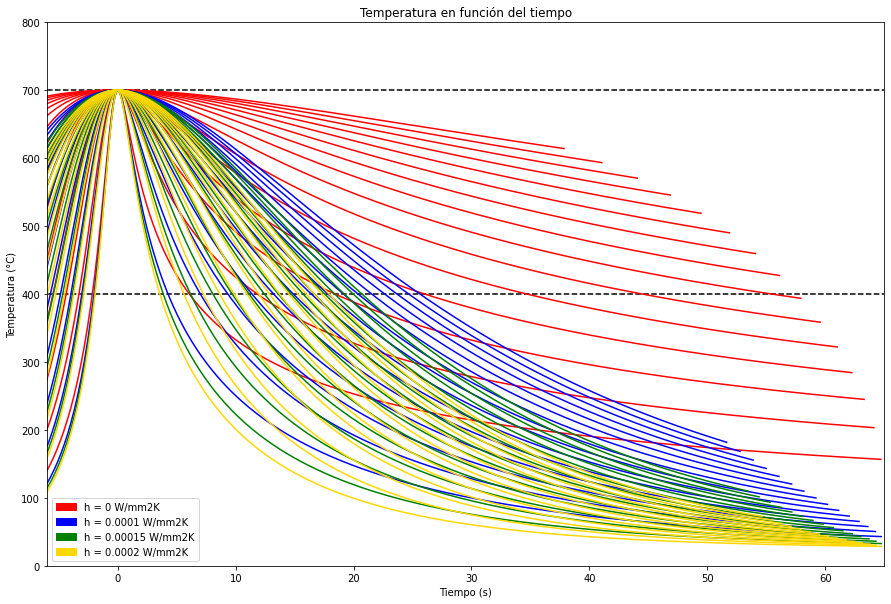

In [7]:
U = 2
b = 2


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=700, color='k', linestyle='dashed')
ax.axhline(y=400, color='k', linestyle='dashed')
plt.ylim((0,800))
plt.xlim((-6,65))
plt.title("Temperatura en función del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")

for h, c in zip([0, 0.0001, 0.00015, 0.0002, 0.00025], ["red","blue","green","gold"]):
    for y in np.linspace(2, 30, 15):
        df_plot2 = df_QUconv[(df_QUconv["b"] == b )& (df_QUconv["y"] == y ) & (df_QUconv["U"] == U) & (df_QUconv["h"] == h)]
        Q = df_plot2.Qmax.values[0]
        t = np.linspace(-6,65,500)
        plt.plot(t-df_plot2["tmax"].values[0], Ros2Dconv((t, b, y, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y, b), color=c)

red_patch = mpatches.Patch(color='red', label="h = 0 W/mm2K")
blue_patch = mpatches.Patch(color='blue', label="h = 0.0001 W/mm2K")
green_patch = mpatches.Patch(color='green', label="h = 0.00015 W/mm2K")
gray_patch = mpatches.Patch(color='gold', label="h = 0.0002 W/mm2K")
ax.legend(handles=[red_patch, blue_patch, green_patch, gray_patch])  

### Se traen los datasets de tres enfriamientos: Diámetro 2.54, diámetro 4, diámetro 6

In [8]:
tiempo_254 = [0.00, 1.00, 1.90, 2.80, 3.90, 4.80, 5.70, 6.70, 7.60, 8.50, 9.50, 10.40, 11.30, 12.30, 13.20, 14.10, 15.20, 16.10, 17.00, 18.10, 18.90, 19.80, 20.80, 21.70, 22.60, 23.70, 24.60, 25.50, 26.50, 27.40, 28.30, 29.30, 30.20, 31.10, 32.10, 33.00, 33.90, 35.00, 35.90, 36.80, 37.80, 38.70, 39.60, 40.60, 41.50, 42.40, 43.40, 44.30, 45.20, 46.30, 47.20, 48.10, 49.10, 50.00, 50.90, 51.90, 52.80, 53.70, 54.70, 55.60, 56.50, 57.60, 58.50, 59.40, 60.40, 61.30, 62.20, 63.20, 64.10, 65.00, 66.00, 66.90, 67.80, 68.90, 69.80, 70.70, 71.70, 72.60, 73.50, 74.50, 75.40, 76.30, 77.30, 78.20, 79.10, 80.20, 81.10, 82.00, 83.00, 83.90, 84.80, 85.80, 86.70, 87.60, 88.60, 89.50, 90.40, 91.50, 92.40, 93.30, 94.30]
tiempo_400 = [0.00,0.90,2.00,2.80,3.70,4.50,5.30,6.30,7.10,8.00,9.00,9.90,10.70,11.90,12.70,13.60,14.40,15.20,16.20,17.00,17.80,18.90,19.80,20.60,21.50,22.30,23.20,24.10,24.90,26.00,26.90,27.70,28.90,29.70,30.60,31.70,32.60,33.40,34.50,35.30,36.20,37.40,38.20,39.10,40.10,41.00,41.80,43.00,43.90,44.70,45.80,46.70,47.50,48.60,49.50,50.30,51.50,52.30,53.20,54.30,55.10,56.00,57.10,58.00,58.90,59.90,60.80,61.60,62.80,63.70,64.50,65.60,66.50,67.30,68.40,69.20,70.10,70.90,71.80,72.60,73.50,74.30,75.50,76.40,77.20,78.30,79.10,80.00,81.10,82.00,82.80,84.00,84.90,85.70,86.80,87.60,88.50,89.70,90.50,91.30,92.40,93.30,94.10,95.30,96.20,97.00,98.10,99.00,99.80,100.90,101.80,102.60,103.80,104.70,105.50,106.60,107.40,108.30,109.40,110.30,111.10,112.20,113.10,113.90,115.10,115.90,116.80,117.90,118.70,119.60,120.70,121.50,122.40,123.60,124.40,125.20,126.30,127.20,128.00,129.20,130.10,130.90,132.00,132.90,133.70,134.90,135.70,136.60,137.70,138.50,139.40,140.50,141.40,142.20,143.40,144.20,145.10,146.10,147.00,147.80,149.00,149.90,150.70,151.80,152.60,153.50,154.70,155.50,156.40,157.50,158.30,159.20,160.20,161.10,161.90,162.80,163.60,164.60,165.40,166.20,167.30,168.20,169.00,170.20,171.10,171.90,173.00,173.80,174.70,175.90,176.70,177.60,178.70,179.50,180.40,181.50,182.40,183.20,184.30,185.20]
tiempo_600 = [0.00,1.20,2.00,2.90,4.00,4.80,5.70,6.80,7.70,8.50,9.60,10.50,11.30,12.50,13.30,14.20,15.30,16.10,17.00,18.10,18.90,19.80,21.00,21.80,22.70,23.70,24.60,25.40,26.60,27.50,28.30,29.40,30.20,31.10,32.20,33.10,33.90,34.70,35.60,36.50,37.30,38.20,39.30,40.10,41.00,42.10,43.00,43.80,44.90,45.80,46.60,47.80,48.70,49.50,50.60,51.40,52.30,53.40,54.20,55.10,56.30,57.10,58.00,59.10,59.90,60.70,61.90,62.80,63.60,64.70,65.60,66.40,67.50,68.40,69.20,70.00,70.90,71.80,72.70,73.50,74.60,75.50,76.30,77.50,78.30,79.10,80.20,81.10,81.90,83.10,84.00,84.80,85.90,86.80,87.60,88.80,89.60,90.50,91.50,92.40,93.20,94.40,95.30,96.10,97.20,98.00,98.90,100.10,100.90,101.80,102.90,103.70,104.60,105.60,106.50,107.30,108.50,109.40,110.20,111.30,112.20,113.00,114.10,115.00,115.80,116.60,117.50,118.40,119.30,120.10,121.20,122.00,122.90,124.10,124.90,125.70,126.80,127.70,128.50,129.70,130.50,131.40,132.50,133.30,134.20,135.30,136.20,137.00,138.20,139.00,139.90]

In [9]:
temperatura_254 = [56.00,55.00,54.00,54.00,53.00,53.00,52.00,15.00,140.00,349.00,530.00,569.00,577.00,583.00,583.00,584.00,583.00,583.00,710.00,686.00,669.00,649.00,630.00,618.00,604.00,588.00,577.00,563.00,547.00,536.00,522.00,509.00,494.00,483.00,471.00,458.00,446.00,432.00,418.00,408.00,395.00,383.00,373.00,360.00,351.00,341.00,332.00,325.00,315.00,306.00,298.00,290.00,281.00,274.00,266.00,258.00,251.00,245.00,239.00,232.00,227.00,220.00,216.00,210.00,204.00,198.00,195.00,190.00,185.00,180.00,175.00,172.00,168.00,164.00,160.00,156.00,153.00,150.00,146.00,143.00,139.00,137.00,134.00,129.00,126.00,123.00,121.00,119.00,116.00,113.00,112.00,109.00,107.00,105.00,102.00,101.00,99.00,97.00,95.00,93.00,91.00]
temperatura_400 = [93.00,93.00,92.00,91.00,90.00,90.00,89.00,89.00,88.00,121.00,197.00,292.00,374.00,497.00,574.00,645.00,685.00,696.00,706.00,710.00,714.00,715.00,717.00,718.00,718.00,718.00,716.00,685.00,671.00,654.00,645.00,638.00,627.00,626.00,623.00,618.00,613.00,609.00,605.00,601.00,596.00,594.00,593.00,592.00,591.00,591.00,588.00,585.00,580.00,575.00,563.00,557.00,551.00,538.00,533.00,528.00,516.00,506.00,499.00,489.00,484.00,479.00,469.00,462.00,455.00,450.00,445.00,439.00,430.00,424.00,416.00,410.00,404.00,398.00,392.00,386.00,382.00,378.00,374.00,369.00,366.00,360.00,353.00,350.00,346.00,341.00,339.00,336.00,329.00,324.00,319.00,313.00,311.00,308.00,307.00,305.00,301.00,296.00,293.00,290.00,287.00,285.00,282.00,278.00,274.00,270.00,266.00,264.00,262.00,258.00,257.00,254.00,250.00,248.00,245.00,241.00,239.00,239.00,237.00,235.00,234.00,232.00,230.00,228.00,226.00,225.00,223.00,220.00,218.00,216.00,214.00,212.00,210.00,208.00,207.00,206.00,204.00,202.00,200.00,197.00,196.00,195.00,193.00,192.00,189.00,188.00,188.00,186.00,184.00,181.00,180.00,177.00,175.00,174.00,171.00,171.00,171.00,168.00,167.00,165.00,163.00,163.00,162.00,160.00,159.00,158.00,157.00,156.00,155.00,154.00,153.00,153.00,152.00,152.00,150.00,148.00,147.00,145.00,144.00,143.00,141.00,141.00,140.00,139.00,138.00,138.00,136.00,136.00,135.00,133.00,134.00,133.00,130.00,129.00,128.00,127.00,127.00,126.00,125.00,124.00]
temperatura_600 = [38,38,38,38,38,38,38,127,245,406,562,655,687,696,699,701,703,708,692,677,672,665,650,644,639,624,617,608,598,588,577,565,559,549,537,529,516,507,499,488,479,472,462,455,445,432,422,414,404,399,390,383,375,367,357,351,347,338,332,325,318,313,309,302,298,293,286,282,279,275,271,266,259,255,251,249,245,240,237,234,228,225,223,219,217,215,211,206,203,198,196,194,190,187,186,182,180,180,177,175,172,168,167,165,162,161,159,156,154,153,150,149,147,144,143,140,138,136,135,133,129,129,127,126,125,123,122,120,120,118,116,116,114,111,111,110,108,106,105,103,103,103,102,100,99,97,96,95,94,92,92]

In [10]:
df_ciclo1 = pd.DataFrame(data = {"tiempo": tiempo_254, "temperatura": temperatura_254})
df_ciclo1["tiemponuevo"] = df_ciclo1["tiempo"]-17

df_ciclo2 = pd.DataFrame(data = {"tiempo": tiempo_400, "temperatura": temperatura_400})
df_ciclo2["tiemponuevo"] = df_ciclo2["tiempo"]-23

df_ciclo3 = pd.DataFrame(data = {"tiempo": tiempo_600, "temperatura": temperatura_600})
df_ciclo3["tiemponuevo"] = df_ciclo3["tiempo"]-16

NameError: name 'df_simulableconv' is not defined

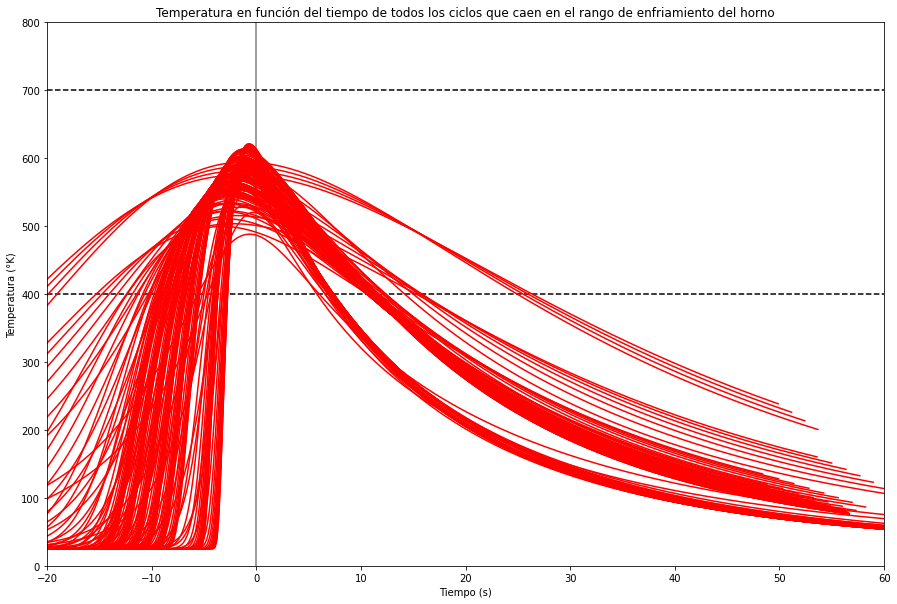

In [11]:
b = 4
h = 0.0002

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=700, color='k', linestyle='dashed')
ax.axhline(y=400, color='k', linestyle='dashed')
plt.ylim((0,800))
plt.xlim((-20,60))
plt.title("Temperatura en función del tiempo de todos los ciclos que caen en el rango de enfriamiento del horno")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°K)")
plt.axvline(x = 0, color = 'gray')

for y in df_simulable.y.unique():
    for U in df_simulable[(df_simulable["y"] == y )].U.unique():
        df_plot = df_simulable[(df_simulable["b"] == b )& (df_simulable["y"] == y ) & (df_simulable["U"] == U)]
        Q = df_plot.Qmax.values[0]
        t = np.linspace(-20,65,500)
        plt.plot((t-df_plot.tmax.values[0]), Ros2Dconv((t, b, y, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y, b), color="red")
        
for y in df_simulableconv.y.unique():
    for U in df_simulableconv[(df_simulableconv["y"] == y )].U.unique():
        df_plott = df_simulableconv[(df_simulableconv["b"] == b )& (df_simulableconv["y"] == y ) & (df_simulableconv["U"] == U)]
        Q = df_plott.Qmax.values[0]
        t = np.linspace(-20,65,500)
        plt.plot((t-df_plott.tmax.values[0]), Ros2Dconv((t, b, y, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y, b), color="blue")


#plt.plot(t, Ros2Dconv((t, 1, 6, 3, 312.72)), color="blue")
plt.plot(df_ciclo1.tiemponuevo,df_ciclo1.temperatura, "o-")
plt.plot(df_ciclo2.tiemponuevo,df_ciclo2.temperatura, "o-")
plt.plot(df_ciclo3.tiemponuevo,df_ciclo3.temperatura, "o-")

In [ ]:
b = 4

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=700, color='k', linestyle='dashed')
ax.axhline(y=400, color='k', linestyle='dashed')
plt.ylim((0,800))
plt.xlim((-20,60))
plt.title("Temperatura en función del tiempo de todos los ciclos que caen en el rango de enfriamiento del horno")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.axvline(x = 0, color = 'gray')

for y in df_simulable.y.unique():
    for U in df_simulable[(df_simulable["y"] == y )].U.unique():
        df_plot = df_simulable[(df_simulable["b"] == b )& (df_simulable["y"] == y ) & (df_simulable["U"] == U)]
        Q = df_plot.Qmax.values[0]
        t = np.linspace(-20,65,500)
        plt.plot((t-df_plot.tmax.values[0]), Ros2D((t, b, y, U, Q)), label="U = {}mm/s, Y = {}mm".format(U, y, b))
plt.plot(df_ciclo1.tiemponuevo,df_ciclo1.temperatura, "o-")
plt.plot(df_ciclo2.tiemponuevo,df_ciclo2.temperatura, "o-")

        
        
#saveimage("ciclosjuntoscelsius")

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=0.6, color='k', linestyle='dashed')
ax.axhline(y=0.8, color='k', linestyle='dashed')
plt.ylim((0,1.4))
plt.xlim((0,3000))
plt.title("Valores de τ")
plt.xlabel("Aporte térmico (J/mm)")
plt.ylabel("τ")
plt.axvline(x = 100,linestyle='dashed', color = 'gray')

for b in range(1,10):
    qu = np.linspace(0.1,3000,500)
    plt.plot(qu, tau(b, r, C, Tmax, T0, qu), label = "b = {}mm".format(b))

plt.legend()
#saveimage("tau")

In [ ]:
b = 4

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=700, color='k', linestyle='dashed')
ax.axhline(y=400, color='k', linestyle='dashed')
plt.ylim((0,800))
plt.xlim((-20,60))
plt.title("Temperatura en función del tiempo de todos los ciclos que caen en el rango de enfriamiento del horno")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.axvline(x = 0, color = 'gray')

for y in [4]:
    for U in df_simulable[(df_simulable["y"] == y )].U.unique():
        df_plot = df_simulable[(df_simulable["b"] == b )& (df_simulable["y"] == y ) & (df_simulable["U"] == U)]
        Q = df_plot.Qmax.values[0]
        t = np.linspace(-20,65,500)
        plt.plot((t-df_plot.tmax.values[0]), Ros2D((t, b, y, U, Q)), label="U = {}mm/s, Y = {}mm".format(U, y, b))
#plt.plot(df_ciclo1.tiemponuevo,df_ciclo1.temperatura, "o-")
#plt.plot(df_ciclo2.tiemponuevo,df_ciclo2.temperatura, "o-")

        
        
#saveimage("ciclostc")

### Acá me traigo un ciclo de la literatura para comparar con Rosenthal

In [12]:
tc2 = [0.00,20.00,25.89,26.74,27.94,28.57,29.23,29.98,30.74,32.00,33.52,36.20,38.34,40.00,42.41,47.43,51.97,55.86,60.00,61.21,68.00,80.00,100.00,107.86,120.00]
tempc2 = [75.09,75.09,94.98,120.00,220.00,320.00,420.00,520.00,620.00,688.00,683.30,657.42,628.02,611.40,566.35,520.00,475.75,452.87,429.98,420.00,383.83,320.00,241.87,220.00,185.62]

df_tc2= pd.DataFrame(data = {"tiempo": tc2, "temperatura": tempc2})
df_tc2["tiemponuevo"] = df_tc2["tiempo"]-32


### y empiezo a colocar los parámetros necesarios de Rosenthal según el paper:

In [13]:
b = 3 #mm
U = 3.7 #mm/s
Q = 370*U #J/s

y1 = 0.96 #mm
y2 = y1 + 3.18 #mm
y3 = y2 + 4.69 #mm

### en esta celda se puede variar el coeficiente de convección para el gráfico que sigue

In [17]:
h = 0.0001 #W/mm2K

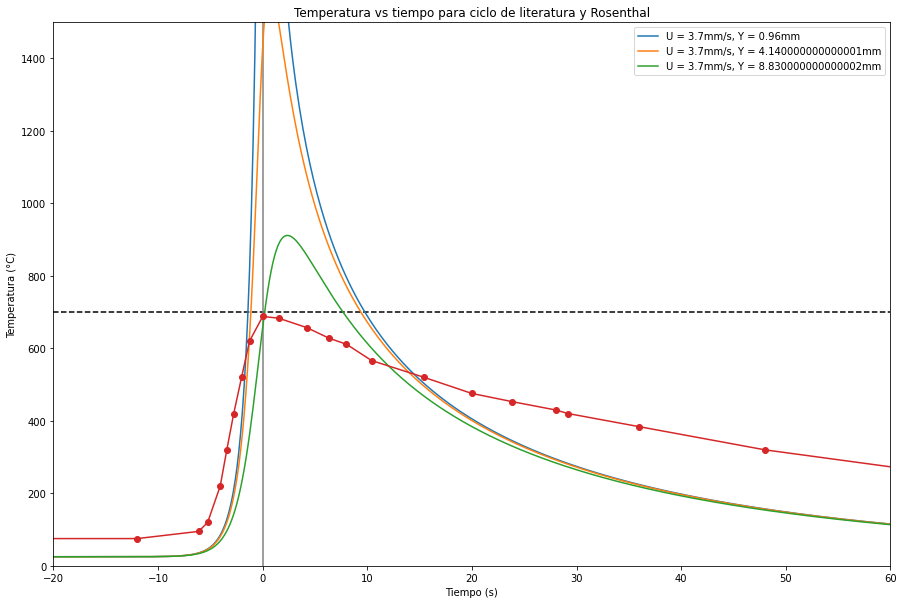

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=700, color='k', linestyle='dashed')
plt.ylim((0,1500))
plt.xlim((-20,60))
plt.title("Temperatura vs tiempo para ciclo de literatura y Rosenthal")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.axvline(x = 0, color = 'gray')

t = np.linspace(-20,65,500)

plt.plot((t), Ros2Dconv((t, b, y1, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y1, b))
plt.plot((t), Ros2Dconv((t, b, y2, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y2, b))
plt.plot((t), Ros2Dconv((t, b, y3, U, h, Q)), label="U = {}mm/s, Y = {}mm".format(U, y3, b))
plt.plot(df_tc2.tiemponuevo, df_tc2.temperatura, "o-")
plt.legend()